<br/><font size="6"><b>Такси в аэропортах. Временные ряды</b></font>.<br/>

<a name="1common."></a>
## <a name="0.0"></a>Содержание:
* [0. Подгрузка библиотек и самописные функции](#0.)
* [1. Подготовка данных](#1.)
* [2. Анализ](#2.)
* [3. Обучение](#3.)
* [4. Тестирование](#4.)
* [5. Проверка модели на адекватность](#5.)
* [Вывод](#6.)

# Описание проекта

На основе исторических данных о заказах такси, нужно построить модель для прогнозирования количества заказов такси на следующий час.

*Значение метрики **RMSE** на тестовой выборке должно быть не больше 48.*

## Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

<a name="0."></a><br/>
<font size="6"><b>0. Подгрузка библиотек и самописные функции</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from termcolor import colored

import warnings
import time
import random
import seaborn as sns
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.exceptions import NotFittedError
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

import lazypredict
from lazypredict.Supervised import LazyRegressor

In [2]:
#Определяем болд
def bold(): 
    return "\033[1m"

def bold_end(): 
    return "\033[0m"

#Ставим формат для нумериков
pd.options.display.float_format = '{: >10.2f}'.format

#Убираем ворнинги
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#**Функция print_basic_info, для вывода информации о массиве, и его переменных.**

#* base - название базы данных
#* info - 1: вывод информации о массиве, другое: не вывод
#* describe - 1: вывод описания переменных массива, другое: не вывод        
#* duplicat - 1: вывод количества полных дублей
#* head - n: вывод примера базы (вывод n - строк), n < 1: не вывод

def print_basic_info(base, info, describe, duplicat, head):
    if info == 1:
        print("\n", bold(), colored('info','green'), bold_end(), "\n")
        print( base.info())  
    if head >= 1:
        print("\n", bold(),colored('head','green'),bold_end())
        display(base.head(head))
    if describe == 1:
        print("\n", bold(),colored('describe','green'),bold_end(),"\n")
        for i in base.columns:
            print("\n", bold(), colored(i,'blue'),bold_end(),"\n", base[i].describe())
    if duplicat == 1:
        print("\n", bold(),colored('duplicated','green'),bold_end(),"\n")
        print(base[base.duplicated() == True][base.columns[0]].count())

<a name="1."></a><br/>
<font size="6"><b>1. Подготовка данных</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

Открывая файл сразу сделаем из даты индекс 

In [5]:
#Работаю локально, онлайн путь в хабе немного другой ('/datasets/...')

df_taxi = pd.read_csv('datasets/taxi.csv', sep=',',decimal='.', index_col = 'datetime', parse_dates=[0])

print_basic_info(df_taxi,1,1,0,3)


  info  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None

  head 


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28



  describe  


  num_orders  
 count     26496.00
mean         14.07
std           9.21
min           0.00
25%           8.00
50%          13.00
75%          19.00
max         119.00
Name: num_orders, dtype: float64


У нас только результат и дата. 

Всего 26496 кейсов. Все заполнены.

In [6]:
df_taxi.sort_index(inplace=True, ascending=False)

In [7]:
# Проверим, что даты монотонные

df_taxi.sort_index(inplace=True, ascending=False)

def is_monotonic(data):
    if data.index.is_monotonic == True:
        print(bold(), colored('Отсортированы по дате','green') , bold_end(), "\n")
        return data
    else:
        print(bold(), colored('Не отсортированы по дате','red') , bold_end(), "\n")
        data.sort_index(inplace=True)
        return is_monotonic(data)

In [8]:
#Для удобства повторения процесса обработки данных будем сделаем функцию

steps_clean = [is_monotonic]

def clean_data(data, steps_clean):
    for step in steps_clean:
        print(bold(), colored((str(step).split()[1]),'blue'), bold_end(), "\n")
        data = step(data)
    return data

data_clean = clean_data(df_taxi, steps_clean)

 is_monotonic  

 Не отсортированы по дате  

 Отсортированы по дате  



In [9]:
# обьединим данные по 1 часу
def resample_h(data):
    data = data.resample('1H').sum()
    print(bold(), colored('Ресемпл - 1 час','green') , bold_end(), "\n")
    return data

step = (resample_h)
if (steps_clean[-1] != step):
        steps_clean.append(step)

data_clean = clean_data(df_taxi, steps_clean)

 is_monotonic  

 Отсортированы по дате  

 resample_h  

 Ресемпл - 1 час  



In [10]:
# посмотрим сколько кейсов
print_basic_info(data_clean,1,1,0,0)


  info  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None

  describe  


  num_orders  
 count      4416.00
mean         84.42
std          45.02
min           0.00
25%          54.00
50%          78.00
75%         107.00
max         462.00
Name: num_orders, dtype: float64


Отлично, кейсов стало меньше т.к данные суммировались

**Добавим информацию по году, месяцу, деню и дню недели**

In [11]:
def data_info(data):
    data['year'] = data.index.year
    print(bold(), colored('Переменная - год','green'), bold_end(), "\n")
    
    data['month'] = data.index.month
    print(bold(), colored('Переменная - месяц','green'), bold_end(), "\n")
    
    data['day'] = data.index.day
    print(bold(), colored('Переменная - день','green'), bold_end(), "\n")
    
    data['dayofweek'] = data.index.dayofweek
    print(bold(), colored('Переменная - день недели','green'), bold_end(), "\n")
    
    data['hour'] = data.index.hour
    print(bold(), colored('Переменная - час','green'), bold_end(), "\n")
    
    return data

step = data_info
if (steps_clean[-1] != step):
        steps_clean.append(step)

data_clean = clean_data(df_taxi, steps_clean)

 is_monotonic  

 Отсортированы по дате  

 resample_h  

 Ресемпл - 1 час  

 data_info  

 Переменная - год  

 Переменная - месяц  

 Переменная - день  

 Переменная - день недели  

 Переменная - час  



In [12]:
print_basic_info(data_clean,1,0,0,0)


  info  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
 1   year        4416 non-null   int64
 2   month       4416 non-null   int64
 3   day         4416 non-null   int64
 4   dayofweek   4416 non-null   int64
 5   hour        4416 non-null   int64
dtypes: int64(6)
memory usage: 241.5 KB
None


<a name="2."></a><br/>
<font size="6"><b>2. Анализ</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

**Чтобы проанализировать данные посмотрим закономерности в целом. 
Возьмем скользящее среднее за день. Также посмотрим тренд**

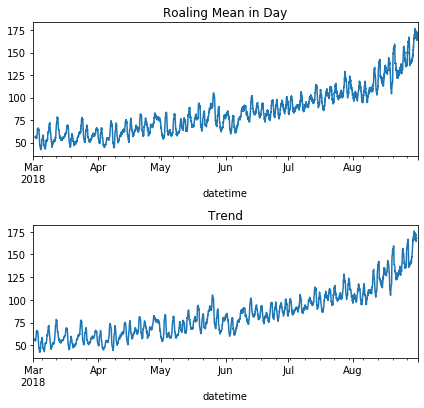

In [13]:
decomposed =  seasonal_decompose(data_clean['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
data_clean['num_orders'].rolling(24).mean().plot()
plt.title('Roaling Mean in Day')
plt.subplot(312)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.tight_layout()

* Скользящее  среднее за день полностью совпадает с рассчитанным трендом. Теперь мы знаем как рассчитывается тренд

* В целом видна тенденция к увеличению заказов

* Однако сезонность оценить не сможем. т.к. у нас данные только за один год.

**Посмотрим зависимость от дня недели**

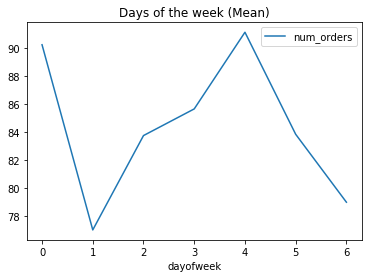

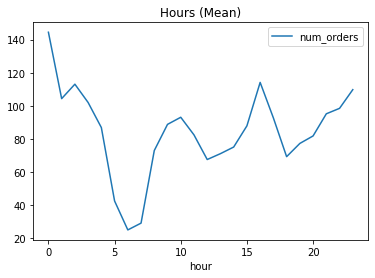

In [14]:
data_clean.pivot_table(index='dayofweek', values='num_orders', aggfunc='mean').plot()
plt.title('Days of the week (Mean)')
plt.show()


data_clean.pivot_table(index='hour', values='num_orders', aggfunc='mean').plot()
plt.title('Hours (Mean)')
plt.show()

* На основании среднего количества вызовов:
    * Самые популярные в дни для вызова такси понедельник и пятница.
    * Пиковое время - около полуночи

<a name="3."></a><br/>
<font size="6"><b>3. Обучение</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

Сделаем удобную функцию, чтобы можно было расчитать сдвиги и среднее скользящее и сразу сделать сплит  на таргет и фичи

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    # согласно тз test_size = 10%
    # shuffle=False т.к работаем с временными рядами и не экстрасенсы
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()

    features_train = train.drop(['num_orders'], axis='columns')
    features_test = test.drop(['num_orders'], axis='columns')
    
    target_train = train['num_orders']
    target_test = test['num_orders']
    
    return features_train, features_test, target_train, target_test
    
# для начала возьмем сдвиг на каждый час в неделе. Среднее скользящее возьмем за сутки 
features_train, features_test, target_train, target_test = make_features(data_clean, 24*7, 24)

In [16]:
print(features_train.shape,target_train.shape, features_test.shape, target_test.shape)

(3806, 174) (3806,) (442, 174) (442,)


**С помощью LazyRegressor прикинем какие модели нам подойдут**

In [17]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )

models,predictions = reg.fit(features_train, features_test, target_train, target_test)

100%|██████████| 38/38 [00:55<00:00,  1.45s/it]


In [18]:
display(models)

,R-Squared,RMSE,Time Taken
Model,,,
LassoCV,0.65,34.43,0.34
LassoLarsCV,0.65,34.45,0.39
LassoLarsIC,0.65,34.88,0.15
Lasso,0.64,34.92,0.08
OrthogonalMatchingPursuit,0.64,34.97,0.06
OrthogonalMatchingPursuitCV,0.64,34.98,0.11
ElasticNetCV,0.64,35.06,0.39
BayesianRidge,0.64,35.08,0.14
RidgeCV,0.63,35.45,0.10


* *Лучше всего работают модели линейной регрессии. Возьмем и внимательно рассмотрим несколько хорошо показавших себя моделей* 

Lasso, OrthogonalMatchingPursuit,  BayesianRidge, Ridge и LinearRegression

In [19]:
#shuffle=False - т.к. нам нужны целые временные куски
cv = KFold(n_splits=5, random_state=1234, shuffle=False)

In [20]:
#Lasso

grid = {'alpha' : [i for i in np.arange(0.1,0.9,0.1)]}

clf = Lasso(random_state = 123)

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_squared_error')
gs.fit(features_train,target_train)

Lasso_best_params = gs.best_params_
print(Lasso_best_params)

{'alpha': 0.8}


In [21]:
#LassoCV

from sklearn.linear_model import LassoCV

grid = {'n_alphas' : [i for i in range(1,20)] }

clf = LassoCV(random_state = 123)

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_squared_error')
gs.fit(features_train,target_train)

LassoCV_best_params = gs.best_params_
print(LassoCV_best_params)

{'n_alphas': 8}


In [22]:
#OrthogonalMatchingPursuit

grid = {'precompute' : [True, False, 'auto']}

clf = OrthogonalMatchingPursuit()

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_squared_error')
gs.fit(features_train,target_train)

OrthogonalMatchingPursuit_best_params = gs.best_params_
print(OrthogonalMatchingPursuit_best_params)

{'precompute': True}


In [23]:
#BayesianRidge

grid = {'n_iter' : [i for i in range(1,200)]}

clf = BayesianRidge()

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_squared_error')
gs.fit(features_train,target_train)

BayesianRidge_best_params = gs.best_params_
print(BayesianRidge_best_params)

{'n_iter': 5}


In [24]:
#Ridge

grid = {'alpha' : [i for i in np.arange(0.1,0.9,0.1)]}

clf = Ridge()

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_squared_error')
gs.fit(features_train,target_train)

Ridge_best_params = gs.best_params_
print(Ridge_best_params)

{'alpha': 0.8}


In [25]:
#LinearRegression

grid = {'normalize' : [True, False]}
clf = LinearRegression()

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_squared_error')
gs.fit(features_train,target_train)

LinearRegression_best_params = gs.best_params_
print(LinearRegression_best_params)

{'normalize': False}


In [26]:
#сделаем фунукцию, котрая будет записывать время обучения, скорость предсказания, и качество предсказания(RMSE)
def put_in_base(model_name, base_res, features_train, target_train):
    features_train.reset_index(drop = True, inplace = True)
    target_train.reset_index(drop = True, inplace = True)
    cv = KFold(n_splits = 3, shuffle=True, random_state=241)
    time_train, time_predict, RMSE = [], [], []
    for train_index, val_index in cv.split(features_train):
        X_train, X_val = features_train.loc[train_index], features_train.loc[val_index]
        y_train, y_val = target_train.loc[train_index], target_train.loc[val_index]
        #время обучения.
        start_time = time.time()
        model_name.fit(X_train, y_train)
        time_train.append(round((time.time() - start_time),3))
        #скорость предсказания.
        start_time = time.time()
        predictions_valid = model_name.predict(X_val)
        time_predict.append(round((time.time() - start_time),3))
        #качество предсказания(RMSE)
        RMSE.append(mean_squared_error(y_val, predictions_valid)**0.5)
    
    base_res.loc[str(clf).split('(')[0],'time_train'] = np.mean(time_train)
    base_res.loc[str(clf).split('(')[0],'time_predict'] = np.mean(time_predict)
    base_res.loc[str(clf).split('(')[0],'RMSE'] = np.mean(RMSE)
    return base_res


In [27]:
ans = pd.DataFrame()

for clf in (Lasso(random_state = 123, alpha = 0.8),
            LassoCV(n_alphas = 5, random_state = 123),
            OrthogonalMatchingPursuit(precompute = False),
            BayesianRidge(n_iter =  5),
            Ridge(random_state = 123, alpha = 0.8),
            LinearRegression(normalize =False)
           ):
    put_in_base(clf, ans, features_train, target_train)
    

In [28]:
display(ans.sort_values(by = 'RMSE'))

,time_train,time_predict,RMSE
LassoCV,0.14,0.00,21.30
OrthogonalMatchingPursuit,0.01,0.00,21.48
BayesianRidge,0.04,0.00,21.49
Lasso,0.22,0.00,21.67
Ridge,0.01,0.00,21.75
LinearRegression,0.02,0.00,21.76


**Будем использовать LassoCV**. У этой модели самый низкий показатель RMSE

<a name="4."></a><br/>
<font size="6"><b>4. Тестирование</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [29]:
#сделаем фунукцию, котрая будет записывать время обучения, скорость предсказания, и качество предсказания(RMSE)
def put_in_base_test(model_name, base_res, features_train, target_train, features_test, target_test):
    
    #время обучения.
    start_time = time.time()
    model_name.fit(features_train, target_train)
    base_res.loc['fin','time_train'] = round((time.time() - start_time),3)
    
    #скорость предсказания.
    start_time = time.time()
    predictions_test = model_name.predict(features_test)
    base_res.loc['fin','time_predict'] = round((time.time() - start_time),3)
    
    #качество предсказания(RMSE)
    base_res.loc['fin','RMSE'] = mean_squared_error(target_test, predictions_test)**0.5
    
    return predictions_test, model_name, base_res

In [30]:
info_final_test = pd.DataFrame()
final_model = LassoCV(n_alphas = 5, random_state = 123)
predictions_test, final_model, info_final_test = put_in_base_test(final_model, info_final_test, 
                                                                  features_train, target_train, 
                                                                  features_test, target_test)

In [31]:
display(info_final_test)

,time_train,time_predict,RMSE
fin,0.23,0.00,34.47


Показатель RMSE ниже чем в максимум по ТЗ, что хорошо.

<a name="5."></a><br/>
<font size="6"><b>5. Проверка модели на адекватность</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

Для проверки на адекватность сравним показатель 
    * с медианой на тестовой выборке
    * с "прошедшим часом"

In [32]:
# Все значения тестовой выборки предсказываются одним и тем же числом (константой). Возьмем медиану
pred_median = np.ones(target_test.shape) * target_train.median()
print("RMSE:", mean_squared_error(target_test, pred_median)**0.5)

RMSE: 86.41465855206327


In [33]:
# Новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1)
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
print("RMSE:", mean_squared_error(target_test, pred_previous)**0.5)

RMSE: 58.856486242815066


RMSE нашей модели значительно ниже.

In [34]:
#### Экспортируем модель 
# сохраняем модель для дальнейшей работы вне книги
joblib.dump(final_model, 'model_taxi_timelines_LassoCV.joblib')

['model_taxi_timelines_LassoCV.joblib']

<a name="6."></a><br/>
<font size="6"><b>Вывод</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

**На основе исторических данных о заказах такси, была построена модель для прогнозирования количества заказов такси на следующий час.**
     
*При оценке модели необходимо минимизировать оценочный критерий **RMSE** (на тестовой выборке его показатель должен быть не больше 48). Наша модель на тестовой выборке имеет RMSE меру в 34 заказа*

**Модель построена на основе информации о поведении клиентов на основе данных:**
    
* ***В рамках подготовки данных произведен модели проведено выделение времени заказа в количественные признаки***
    * year - год
    * month - месяц
    * day - день
    * dayofweek - день недели
    * hour - час
    
* ***А также на основе данных о заказах в прошлые часы выделены переменные***
    * lag_... - сдвиг в количестве заказов на каждый час в неделе (всего 24 * 7 переменных)
    * rolling_mean - среднее скользящее за сутки  
    
    
***Целевой признак***

*num_orders — число заказов*


**Модель построена с помощью "LassoCV", c параметрами :**

* n_alphas = 5
* random_state = 123


**Вы можете скачать модель с названием <font color='blue'>  model_taxi_timelines_LassoCV.joblib
</font>**